# Tutorial overview

In questo primo notebook è mostreremo quali sono le funzionalità che vanno implementate "under the hood" in un semplice modello di Machine Learning: la regressione lineare.

## Tematiche
In questo tutorial:
1. Vedremo in che modo importare e visualizzare i dati necessari per il training;
2. Implementeremo tutte le funzionalità di una regressione lineare;
3. Implementeremo un metodo di ottimizzazione per il modello;
3. Alleneremo il modello di regressione sui dati;
4. Visualizzeremo il risultato del training.

Le librerie che utilizzeremo sono:
1. `pandas` per l'import e la visualizzazione delle statistiche dei dati (una specie di excel versione python);
2. `numpy`, una libreria che supporta il calcolo con matrici, array e tensori, per la parte di calcolo scientifico coinvolta nella definizione della regressione lineare;
3. `matplotlib` per la visualizzazione dei grafici. 

## Caso d'uso
Questo task lo eseguiremo sul dataset [Housing Prices](https://www.kaggle.com/camnugent/california-housing-prices), nel quale vengono fornite diverse caratteristiche quali metratura dell'immobile, anno di costruzione, numero di piani, anno di eventuali ristrutturazioni e molte altre. 

L'**obiettivo** sarà quello di predire il prezzo di vendita di una casa a partire dalle features sopra descritte.


## Perché questo tutorial?
L'intenzione di questo tutorial è quella di mostrare a che livelli di complessità di può arrivare anche con un task molto semplice, e le ragioni per cui dobbiamo utilizzare strumenti più "potenti". 😀

# Un po' di burocrazia...

Importiamo le librerie e settiamo alcuni parametri che saranno utili successivamente.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import unittest

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
rcParams['animation.embed_limit'] = 2**128

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Lavoriamo col dataset

Il primo passo, ovviamente, è il **download** del dataset. 

Colab, e in generale i Jupyter Notebooks, offrono la possibilità di utilizzare comandi della bash inserendo `!` prima della riga di codice.

In [2]:
! wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv

--2021-12-02 16:08:36--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv.1’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.04s   

2021-12-02 16:08:36 (11.6 MB/s) - ‘house_prices_train.csv.1’ saved [460676/460676]



Abbiamo il dataset, non rimane che **importarlo**.

`pandas` fornisce diverse funzionalità per importare un dataset da file, a seconda del formato in cui ci viene fornito. In questo caso, il formato è `.csv`

In [3]:
train_df = pd.read_csv('house_prices_train.csv')

Con il metodo `.head` dei `pd.Dataframe` possiamo listare le prime 10 righe del dataframe in maniera esplicita. Risulta particolarmente utile per comprendere il formato dei dati, i valori e farsi un'idea sommaria di cosa abbiamo.

In [4]:
train_df.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

Il metodo `.describe()` dà una valutazione statistica di tutte le colonne numeriche.

In [5]:
train_df.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

Possiamo verificare la coerenza di quanto descritto plottando il grafico della distribuzione di `train_df['SalePrice']`.

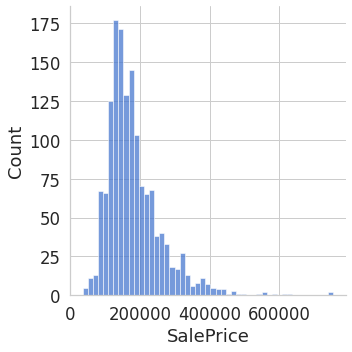

In [6]:
sns.displot(train_df['SalePrice'])

Dal punto di vista teorico, una regressione lineare cerca di rappresentare una correlazione fra le features e i labels che vogliamo predire, quindi è importante identificare quali sono le features correlate con il nostro label.

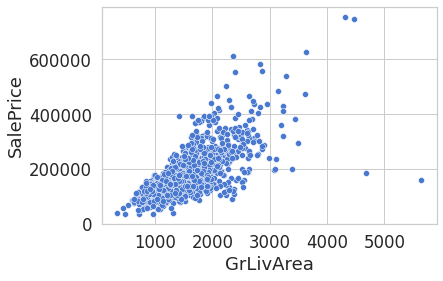

In [7]:
feat = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[feat]], axis=1)
sns.scatterplot(data=data, x=feat, y='SalePrice')

Bene! Abbiamo identificato che c'è una buona correlazione lineare fra la colonna `GrLivArea` (la superficie totale, in metri quadri) e `SalePrice`. Possiamo passare alla costruzione della nostra regressione lineare.

In [12]:
features, y_true = train_df['GrLivArea'].values, train_df['SalePrice'].values

# Design della regressione lineare e dell'ottimizzazione

La regressione lineare è definita nel seguente modo:
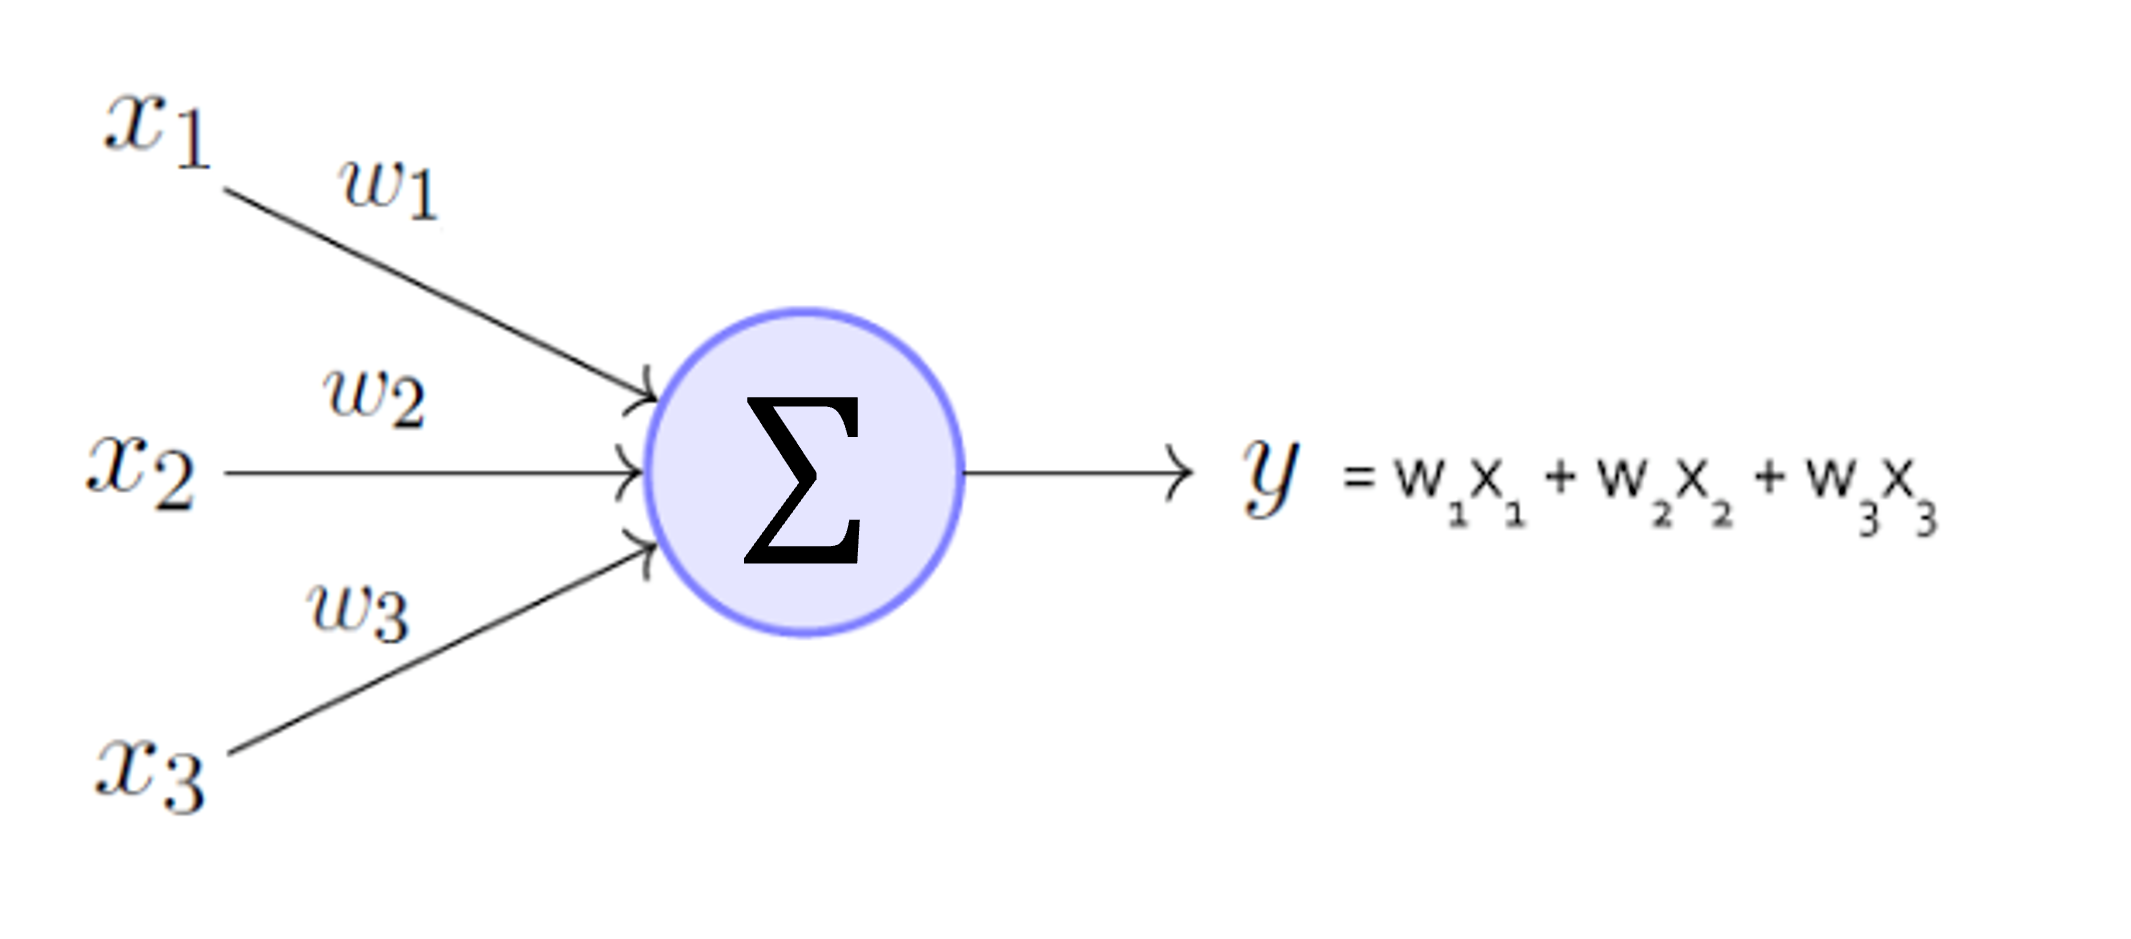

ed è forse il modello di Machine Learning più basilare in assoluto.

In questo caso vogliamo ottimizzarla cercando di minimizzare la loss con discesa di gradiente.

In [33]:
class LinearRegression:

  def __init__(self):
    
    self._W = np.zeros(2)
    self._cost_history = []
    self._w_history = [self._W]
  
  def predict(self, X):
    return np.dot(X, self._W)
  
  def _gradient_descent_step(self, X, gradient, lr):
    gradient = np.dot(X.T,  gradient) / len(X)
    self._W -= lr * gradient
      
  def fit(self, X, y_true, loss, n_iter=100000, lr=0.01):

    for i in range(n_iter):
        y_pred = self.predict(X)
        cost, gradient = loss(y_true, y_pred)
        self._gradient_descent_step(X, gradient, lr)

        self._cost_history.append(cost / len(X))
        self._w_history.append(self._W.copy())
        
    return self

Come funzione di penalizzazione (loss) utilizziamo lo Squared Error, ovvero
```
SE = 1/2 * sum((y_true - y_pred)**2)
```
e ha come gradiente rispetto a `y_pred`
```
grad(SE, y_pred) = y_pred - y_true
```

In [34]:
def SE(y_true, y_pred):
  sq_error = (y_true - y_pred)**2
  n = len(y_true)

  cost = 1.0 / (2*n) * sq_error.sum()
  gradient = y_pred - y_true 
  return cost, gradient

# Training
Una volta fatto tutto il lavoro sporco, per il training è sufficiente inizializzare il modello e chiamare il nostro metodo `.fit`.

In [35]:
model = LinearRegression()

features_with_bias = np.stack([features, np.ones(features.shape[0])], axis=1)
model.fit(features_with_bias, y_true, SE, n_iter=150, lr=1e-7)

print(model._W, len(model._cost_history))

[1.18069042e+02 9.94290254e-02] 150


Vediamo come si è comportato il modello.

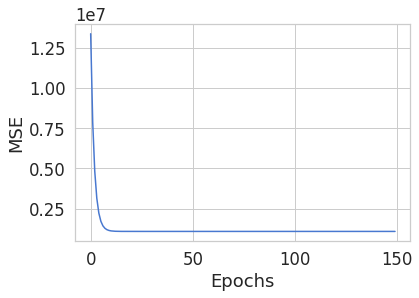

In [38]:
ax = sns.lineplot(data=model._cost_history)
ax.set(xlabel='Epochs', ylabel='MSE')
plt.show()

Visualizziamo l'animazione del training.

In [47]:
#Animation
def animate(clf, x, y, frames=150):
    #Set the plot up
    fig = plt.figure()
    ax = plt.axes()
    plt.title('Sale Price vs Living Area')
    plt.xlabel('Living Area in square feet')
    plt.ylabel('Sale Price ($)')
    plt.scatter(x, y)

    line, = ax.plot([], [], lw=2, color='red')
    annotation = ax.text(50, 600000, '')
    # optimal
    x = np.linspace(0, 7000, 1000)
    y = clf._W[1]*x + clf._W[0]
    ax.plot(x, y, 'g--')
    annotation.set_animated(True)
    plt.close()

    def init():
        line.set_data([], [])
        annotation.set_text('')
        return line, annotation

    def animate(i):
        # x = np.linspace(-5, 20, 1000)
        x = np.linspace(0, 7000, 1000)
        y = clf._w_history[i][0]*x + clf._w_history[i][1]
        line.set_data(x, y)
        annotation.set_text(
            'Cost = %.2f e10\nWeight: %.2f\nBias: %.2f' % 
            (clf._cost_history[i]/1e10, clf._w_history[i][1],
             clf._w_history[i][0]))
        return line, annotation

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=frames, interval=10, blit=True)

    rc('animation', html='jshtml')

    return anim

In [48]:
anim = animate(model, features, y_true)
anim

Siamo arrivati alla fine di questo primo tutorial e, come promesso, vi devo dire le motivazioni.

Tutto ciò che abbiamo fatto finora è: 
1. Hardcodato a una sola strategia;
2. Inefficiente;
3. Ha richiesto una quantità di lavoro per cui, se volessimo farlo efficiente e con backend che lavori in GPU, richiederebbe un mese di lavoro e competenze specializzate.